## Load & Extract

#### Libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#### Read in data

In [232]:
df = pd.read_csv('yahoo.csv')

In [233]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-12-27,20.299999,20.299999,20.299999,20.299999,20.299999,2940000
1,1950-12-28,20.379999,20.379999,20.379999,20.379999,20.379999,3560000
2,1950-12-29,20.430000,20.430000,20.430000,20.430000,20.430000,3440000
3,1951-01-02,20.770000,20.770000,20.770000,20.770000,20.770000,3030000
4,1951-01-03,20.690001,20.690001,20.690001,20.690001,20.690001,3370000


In [234]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
17611,2020-12-18,3722.389893,3726.699951,3685.840088,3709.409912,3709.409912,7068340000
17612,2020-12-21,3684.280029,3702.899902,3636.479980,3694.919922,3694.919922,4732160000
17613,2020-12-22,3698.080078,3698.260010,3676.159912,3687.260010,3687.260010,4023940000
17614,2020-12-23,3693.419922,3711.239990,3689.280029,3690.010010,3690.010010,3772630000
17615,2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,3703.060059,1885090000


In [235]:
df.shape

(17616, 7)

#### Train Test Split

In [236]:
test_size=int(df.shape[0]*0.3)

In [237]:
df_train = df.iloc[:, 1:2].values[:-test_size]

In [238]:
df_train.shape

(12332, 1)

In [239]:
df_test = df.iloc[:, 1:2].values[-test_size:]

In [240]:
df_test.shape

(5284, 1)

## EDA

#### Plot

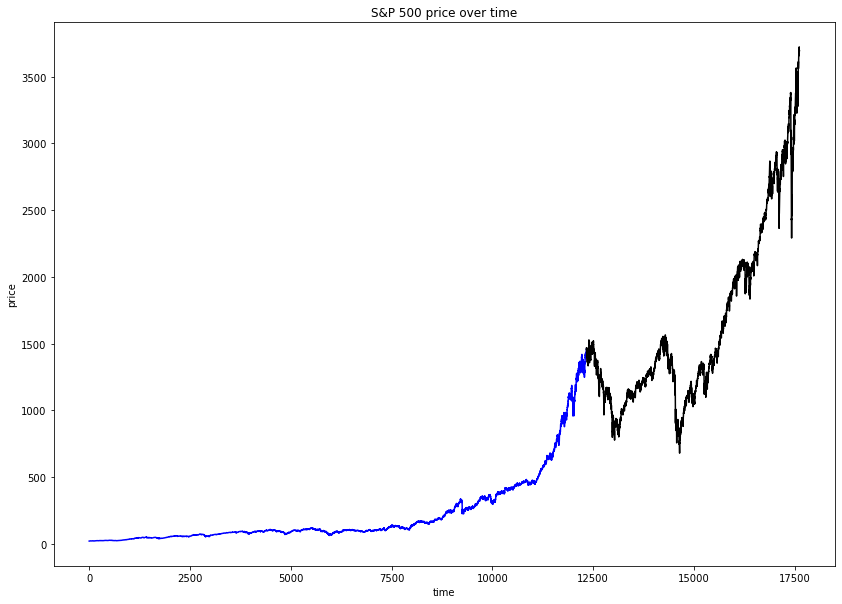

In [318]:
plt.figure(figsize=(14,10))
plt.plot(list(range(0, len(df_train))), df_train, c="blue", label="train")
plt.plot(list(range(len(df_train), len(df_train)+len(df_test))),df_test, c="black", label="test")
plt.title("S&P 500 price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

#### Autocorrelation

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

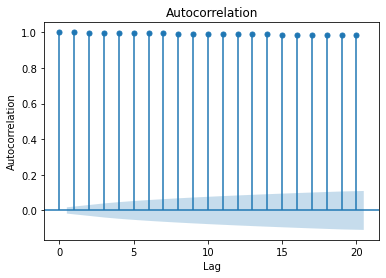

In [340]:
plot_acf(df_train, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

#### Partial Autocorrelation

In [310]:
from statsmodels.graphics.tsaplots import plot_pacf

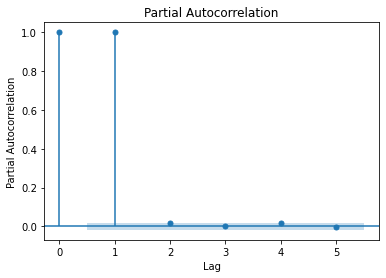

In [339]:
plot_pacf(df_train, lags=5)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

#### AR Model

In [313]:
import warnings
warnings.filterwarnings("ignore")

In [311]:
from statsmodels.tsa.ar_model import AR

Lag: 1
Coefficients: [-0.04376651  1.00074028]


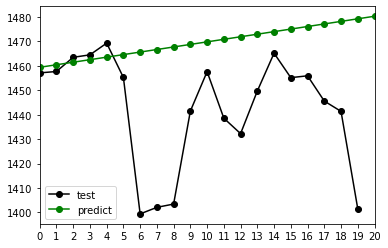

In [337]:
model = AR(df_train)
model_fit = model.fit(maxlag=1)

print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(df_train), end=len(df_train)+20)

plt.figure()
plt.plot(df_test[:20], c="black", label="test", marker='o')
plt.plot(predictions, c="green", label="predict", marker='o')
plt.xlim([0, 20])
plt.xticks(np.arange(0, 21))
plt.legend()
plt.show();

#### MA Model

In [332]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Coefficients: [4.13429830e-02 2.54093151e+00 3.66832085e+00 3.45823382e+00
 2.12718811e+00 7.07399248e-01 2.77928180e+02]


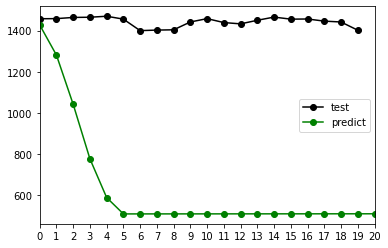

In [338]:
model = SARIMAX(df_train, order=(0, 0, 5), trend="t") 
model_fit = model.fit()

print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(df_train), end=len(df_train)+20)

plt.figure()
plt.plot(df_test[:20], c="black", label="test", marker='o')
plt.plot(predictions, c="green", label="predict", marker='o')
plt.xlim([0, 20])
plt.xticks(np.arange(0, 21))
plt.legend()
plt.show();

## Data Preprocessing

#### Scaling

In [345]:
sc = MinMaxScaler()
df_train_scaled = sc.fit_transform(df_train)
df_test_scaled = sc.transform(df_test)

In [329]:
df_train_scaled.shape

(12332, 1)

In [301]:
df_test_scaled.shape

(5284, 1)

#### Feature/Target

In [247]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [248]:
X_train, y_train = split_sequence(df_train_scaled, 60)

In [249]:
X_train.shape

(12272, 60, 1)

In [250]:
y_train.shape

(12272, 1)

In [251]:
X_test, y_test = split_sequence(df_test_scaled,60)

In [346]:
X_test.shape

(5224, 60, 1)

In [253]:
y_test.shape

(5224, 1)

## LSTM

In [281]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

#### Single Layer

In [378]:
model = Sequential()

model.add(LSTM(50, input_shape = (X_train.shape[1], 1)))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

history = model.fit(X_train, y_train, validation_split = 0.2, epochs = 100, verbose = 1)

Epoch 1/100
307/307 [==============================] - 11s 27ms/step - loss: 6.0972e-04 - val_loss: 1.8645e-04
Epoch 2/100
307/307 [==============================] - 8s 25ms/step - loss: 3.5595e-06 - val_loss: 5.7131e-04
Epoch 3/100
307/307 [==============================] - 7s 22ms/step - loss: 4.7652e-06 - val_loss: 4.6361e-04
Epoch 4/100
307/307 [==============================] - 7s 22ms/step - loss: 3.9113e-06 - val_loss: 3.1842e-04
Epoch 5/100
307/307 [==============================] - 7s 23ms/step - loss: 3.8756e-06 - val_loss: 3.3185e-04
Epoch 6/100
307/307 [==============================] - 7s 23ms/step - loss: 3.6232e-06 - val_loss: 2.3529e-04
Epoch 7/100
307/307 [==============================] - 7s 23ms/step - loss: 3.4596e-06 - val_loss: 2.0346e-04
Epoch 8/100
307/307 [==============================] - 7s 23ms/step - loss: 2.8978e-06 - val_loss: 1.5296e-04
Epoch 9/100
307/307 [==============================] - 7s 23ms/step - loss: 3.7247e-06 - val_loss: 1.6526e-04
Epoch 10/

Epoch 75/100
307/307 [==============================] - 9s 28ms/step - loss: 1.2540e-06 - val_loss: 4.8161e-05
Epoch 76/100
307/307 [==============================] - 8s 26ms/step - loss: 9.5942e-07 - val_loss: 4.4296e-05
Epoch 77/100
307/307 [==============================] - 8s 26ms/step - loss: 9.5188e-07 - val_loss: 3.7092e-05
Epoch 78/100
307/307 [==============================] - 8s 25ms/step - loss: 1.0924e-06 - val_loss: 3.2604e-05
Epoch 79/100
307/307 [==============================] - 8s 26ms/step - loss: 1.0224e-06 - val_loss: 3.5784e-05
Epoch 80/100
307/307 [==============================] - 9s 28ms/step - loss: 1.0078e-06 - val_loss: 3.8412e-05
Epoch 81/100
307/307 [==============================] - 10s 32ms/step - loss: 8.7358e-07 - val_loss: 4.2575e-05
Epoch 82/100
307/307 [==============================] - 9s 31ms/step - loss: 9.8305e-07 - val_loss: 5.6693e-05
Epoch 83/100
307/307 [==============================] - 11s 36ms/step - loss: 1.3949e-06 - val_loss: 5.1431e-05

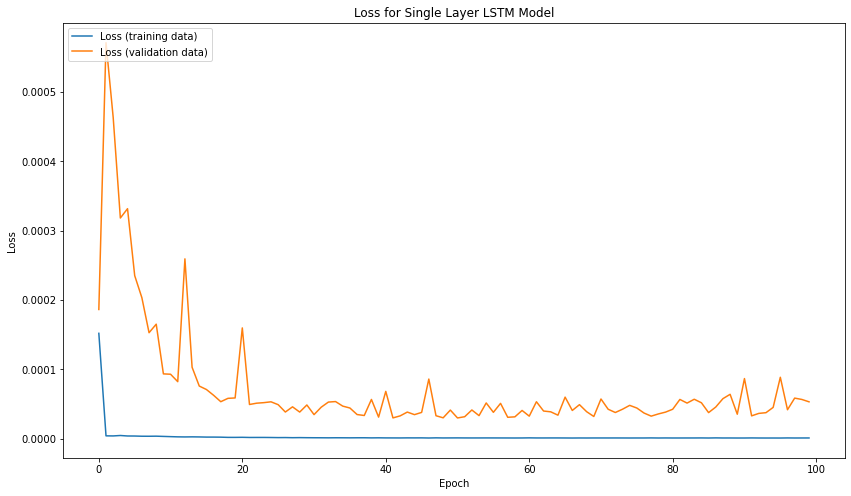

In [380]:
plt.figure(figsize=(14,8))
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Single Layer LSTM Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=2)
plt.show()

#### Stacked

In [320]:
model = Sequential()

model.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

history = model.fit(X_train, y_train, validation_split = 0.2, epochs = 100, verbose = 1)

Epoch 1/100
307/307 [==============================] - 45s 117ms/step - loss: 4.2028e-04 - val_loss: 0.0018
Epoch 2/100
307/307 [==============================] - 31s 101ms/step - loss: 6.0772e-05 - val_loss: 0.0013
Epoch 3/100
307/307 [==============================] - 31s 101ms/step - loss: 4.4357e-05 - val_loss: 0.0015
Epoch 4/100
307/307 [==============================] - 31s 101ms/step - loss: 4.7196e-05 - val_loss: 0.0015
Epoch 5/100
307/307 [==============================] - 30s 98ms/step - loss: 4.7882e-05 - val_loss: 0.0035
Epoch 6/100
307/307 [==============================] - 35s 114ms/step - loss: 4.1443e-05 - val_loss: 6.3255e-04
Epoch 7/100
307/307 [==============================] - 31s 100ms/step - loss: 4.1512e-05 - val_loss: 0.0019
Epoch 8/100
307/307 [==============================] - 32s 104ms/step - loss: 3.4901e-05 - val_loss: 0.0016
Epoch 9/100
307/307 [==============================] - 32s 105ms/step - loss: 3.8709e-05 - val_loss: 0.0021
Epoch 10/100
307/307 [===

307/307 [==============================] - 26s 84ms/step - loss: 2.3828e-05 - val_loss: 0.0920
Epoch 77/100
307/307 [==============================] - 26s 85ms/step - loss: 2.3774e-05 - val_loss: 0.0856
Epoch 78/100
307/307 [==============================] - 26s 85ms/step - loss: 2.5515e-05 - val_loss: 0.0825
Epoch 79/100
307/307 [==============================] - 27s 89ms/step - loss: 2.8210e-05 - val_loss: 0.0930
Epoch 80/100
307/307 [==============================] - 26s 86ms/step - loss: 2.5950e-05 - val_loss: 0.0863
Epoch 81/100
307/307 [==============================] - 27s 89ms/step - loss: 2.2359e-05 - val_loss: 0.0817
Epoch 82/100
307/307 [==============================] - 28s 92ms/step - loss: 2.5243e-05 - val_loss: 0.0902
Epoch 83/100
307/307 [==============================] - 27s 89ms/step - loss: 2.2068e-05 - val_loss: 0.0869
Epoch 84/100
307/307 [==============================] - 27s 89ms/step - loss: 2.6652e-05 - val_loss: 0.0858
Epoch 85/100
307/307 [===================

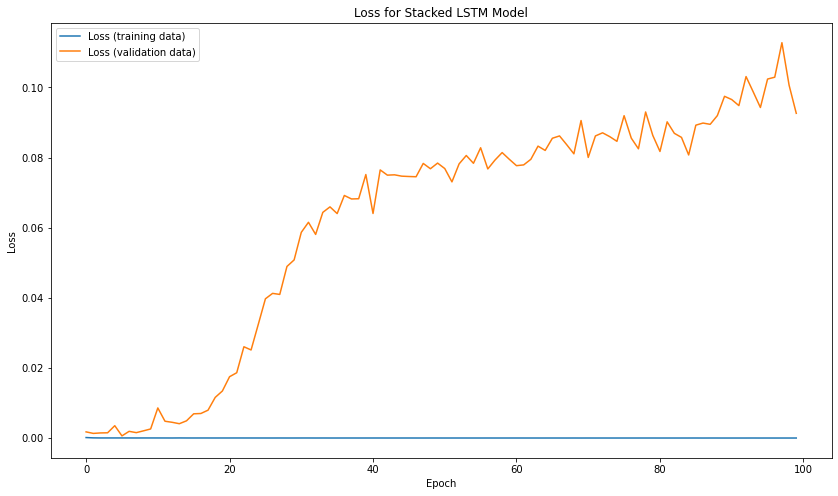

In [321]:
plt.figure(figsize=(14,8))
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Stacked LSTM Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=2)
plt.show()

#### Prediction

In [381]:
y_pred = model.predict(X_test, verbose=1)

164/164 [==============================] - 2s 11ms/step


In [383]:
y_pred = sc.inverse_transform(y_pred)

In [384]:
y_true = sc.inverse_transform(y_test)

In [372]:
y_true.shape

(5224, 1)

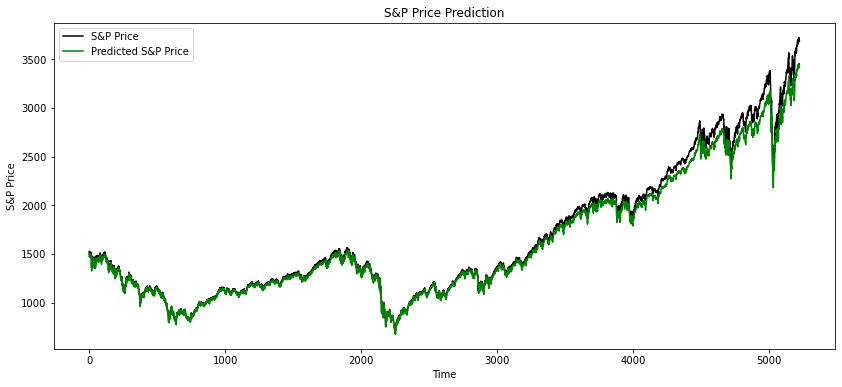

In [385]:
plt.figure(figsize=(14,6))
plt.plot(y_true, color = 'black', label = 'S&P Price')
plt.plot(y_pred, color = 'green', label = 'Predicted S&P Price')
plt.title('S&P Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P Price')
plt.legend()
plt.show()

#### Evaluation

In [270]:
from sklearn.metrics import r2_score

In [386]:
r2_score(y_true,y_pred)

0.9884409206490244

In [387]:
pred = model.predict(X_train, verbose=1)

384/384 [==============================] - 3s 7ms/step


In [388]:
pred = sc.inverse_transform(pred)

In [389]:
true = sc.inverse_transform(y_train)

In [391]:
r2_score(true,pred)

0.9996799492919298

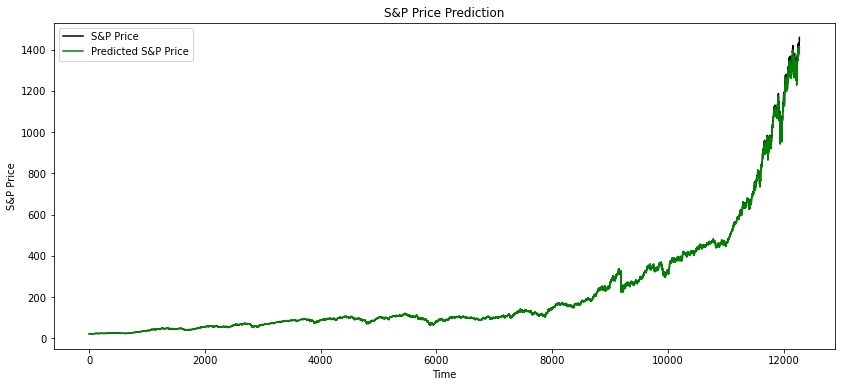

In [390]:
plt.figure(figsize=(14,6))
plt.plot(true, color = 'black', label = 'S&P Price')
plt.plot(pred, color = 'green', label = 'Predicted S&P Price')
plt.title('S&P Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P Price')
plt.legend()
plt.show()

## Bidirectional LSTM

In [393]:
from tensorflow.keras.layers import Bidirectional

In [394]:
model = Sequential()

model.add(Bidirectional(LSTM(50, input_shape = (X_train.shape[1], 1))))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

history = model.fit(X_train, y_train, validation_split = 0.2, epochs = 100, verbose = 1)

Epoch 1/100
307/307 [==============================] - 22s 44ms/step - loss: 5.5249e-04 - val_loss: 2.3131e-04
Epoch 2/100
307/307 [==============================] - 11s 36ms/step - loss: 9.6309e-06 - val_loss: 9.2702e-04
Epoch 3/100
307/307 [==============================] - 14s 47ms/step - loss: 9.4358e-06 - val_loss: 7.7318e-04
Epoch 4/100
307/307 [==============================] - 13s 41ms/step - loss: 7.8346e-06 - val_loss: 5.0318e-04
Epoch 5/100
307/307 [==============================] - 11s 36ms/step - loss: 5.2359e-06 - val_loss: 5.9410e-04
Epoch 6/100
307/307 [==============================] - 11s 36ms/step - loss: 4.8334e-06 - val_loss: 3.8280e-04
Epoch 7/100
307/307 [==============================] - 11s 35ms/step - loss: 4.1437e-06 - val_loss: 2.9045e-04
Epoch 8/100
307/307 [==============================] - 11s 36ms/step - loss: 4.0613e-06 - val_loss: 2.9363e-04
Epoch 9/100
307/307 [==============================] - 10s 34ms/step - loss: 4.4446e-06 - val_loss: 2.3939e-04
E

307/307 [==============================] - 8s 26ms/step - loss: 8.9593e-07 - val_loss: 3.5728e-05
Epoch 75/100
307/307 [==============================] - 7s 24ms/step - loss: 1.3417e-06 - val_loss: 8.1259e-05
Epoch 76/100
307/307 [==============================] - 7s 24ms/step - loss: 8.9967e-07 - val_loss: 3.8019e-05
Epoch 77/100
307/307 [==============================] - 7s 24ms/step - loss: 1.0823e-06 - val_loss: 6.5040e-05
Epoch 78/100
307/307 [==============================] - 7s 24ms/step - loss: 1.1018e-06 - val_loss: 5.0574e-05
Epoch 79/100
307/307 [==============================] - 8s 25ms/step - loss: 1.1804e-06 - val_loss: 4.9283e-05
Epoch 80/100
307/307 [==============================] - 8s 25ms/step - loss: 1.3169e-06 - val_loss: 8.0707e-05
Epoch 81/100
307/307 [==============================] - 8s 25ms/step - loss: 1.0997e-06 - val_loss: 8.8045e-05
Epoch 82/100
307/307 [==============================] - 8s 24ms/step - loss: 1.1075e-06 - val_loss: 7.0807e-05
Epoch 83/100
3

In [397]:
y_pred = model.predict(X_test, verbose=1)

164/164 [==============================] - 2s 9ms/step


In [398]:
y_pred = sc.inverse_transform(y_pred)

In [399]:
y_true = sc.inverse_transform(y_test)

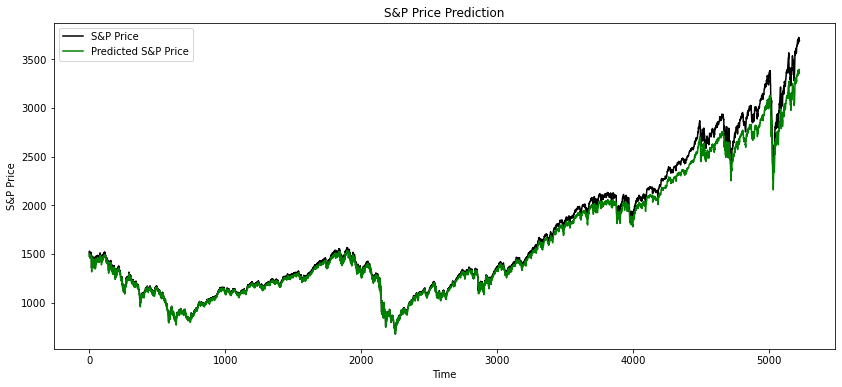

In [400]:
plt.figure(figsize=(14,6))
plt.plot(y_true, color = 'black', label = 'S&P Price')
plt.plot(y_pred, color = 'green', label = 'Predicted S&P Price')
plt.title('S&P Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P Price')
plt.legend()
plt.show()

In [401]:
r2_score(y_true,y_pred)

0.9837502817909594